In [38]:
import gymnasium as gym
from stable_baselines3 import SAC,DDPG
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#Epsilon-Greedy
def epsilon_greedy(Q_values, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(Q_values))
    else:
        return np.argmax(Q_values)

In [5]:
#Softmax
def softmax(Q_values, temperature):
    exp_values = np.exp((Q_values - np.max(Q_values)) / temperature)
    probabilities = exp_values / exp_values.sum()
    return np.random.choice(len(Q_values), p=probabilities)

In [6]:
#UCB1 (Upper Confidence Bound)
def ucb1(Q_values, counts, total_counts):
    ucb_values = Q_values + np.sqrt((2 * np.log(total_counts)) / counts)
    return np.argmax(ucb_values)

# DDPG

In [40]:
# DDPG использует epsilon-greedy стратегию, добавляя шум к выбранному действию во время исследования.
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
env = gym.make('MountainCarContinuous-v0')
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

In [41]:
# Обучим
model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1)
model.learn(total_timesteps=10000, log_interval=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 999      |
|    ep_rew_mean     | -5.08    |
| time/              |          |
|    episodes        | 1        |
|    fps             | 5530     |
|    time_elapsed    | 0        |
|    total_timesteps | 999      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 999      |
|    ep_rew_mean     | -3.03    |
| time/              |          |
|    episodes        | 2        |
|    fps             | 981      |
|    time_elapsed    | 2        |
|    total_timesteps | 1998     |
| train/             |          |
|    actor_loss      | 0.0466   |
|    critic_loss     | 0.00025  |
|    learning_rate   | 0.001    |
|    n_updates       | 999      |
---------------------------------
---------------------------------
| rollout/           

In [42]:
import gym
from IPython import display
from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
from matplotlib import animation

In [43]:
import stable_baselines3
stable_baselines3.__version__

'2.2.1'

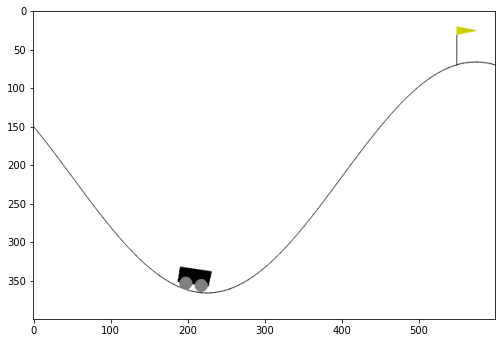

In [44]:
# Тестирование
d = Display()
d.start()
env = gym.make('MountainCarContinuous-v0')

obs = env.reset()
rew_DAC = []
img = []
for _ in range(100):
    action, _states = model.predict(obs)
    obs, reward, terminated, truncated = env.step(action)
    
    rew_DAC.append(reward)
    img.append(env.render('rgb_array'))

    display.clear_output(wait=True)

    if terminated:
        env.reset()
        break

dpi = 72
interval = 20 # ms

plt.figure(figsize=(img[0].shape[1]/dpi,img[0].shape[0]/dpi),dpi=dpi)
patch = plt.imshow(img[0])
plt.axis=('off')
animate = lambda i: patch.set_data(img[i])
ani = animation.FuncAnimation(plt.gcf(),animate,frames=len(img),interval=interval)
display.display(display.HTML(ani.to_jshtml()))

# SAC

In [27]:
env = gym.make('MountainCarContinuous-v0')
model = SAC("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000, log_interval=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 999      |
|    ep_rew_mean     | -33.2    |
| time/              |          |
|    episodes        | 1        |
|    fps             | 318      |
|    time_elapsed    | 3        |
|    total_timesteps | 999      |
| train/             |          |
|    actor_loss      | -3.26    |
|    critic_loss     | 0.00578  |
|    ent_coef        | 0.764    |
|    ent_coef_loss   | -0.451   |
|    learning_rate   | 0.0003   |
|    n_updates       | 898      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 999      |
|    ep_rew_mean     | -33      |
| time/              |          |
|    episodes        | 2        |
|    fps             | 306      |
|    time_elapsed    | 6        |
|    total_timesteps | 1998     |
| train/             

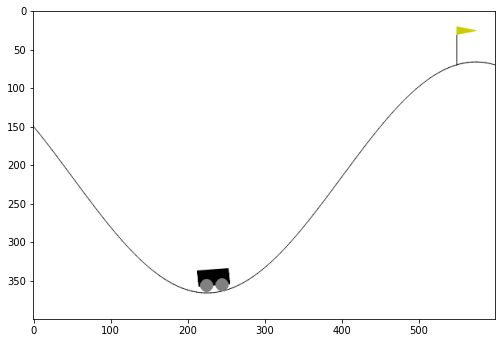

In [32]:
# Тестирование
d = Display()
d.start()
env = gym.make('MountainCarContinuous-v0')

obs = env.reset()
rew_SAC = []
img = []
for _ in range(100):
    action, _states = model.predict(obs)
    obs, reward, terminated, truncated = env.step(action)
    
    rew_SAC.append(reward)
    img.append(env.render('rgb_array'))

    display.clear_output(wait=True)

    if terminated:
        env.reset()
        break

dpi = 72
interval = 20 # ms

plt.figure(figsize=(img[0].shape[1]/dpi,img[0].shape[0]/dpi),dpi=dpi)
patch = plt.imshow(img[0])
plt.axis=('off')
animate = lambda i: patch.set_data(img[i])
ani = animation.FuncAnimation(plt.gcf(),animate,frames=len(img),interval=interval)
display.display(display.HTML(ani.to_jshtml()))

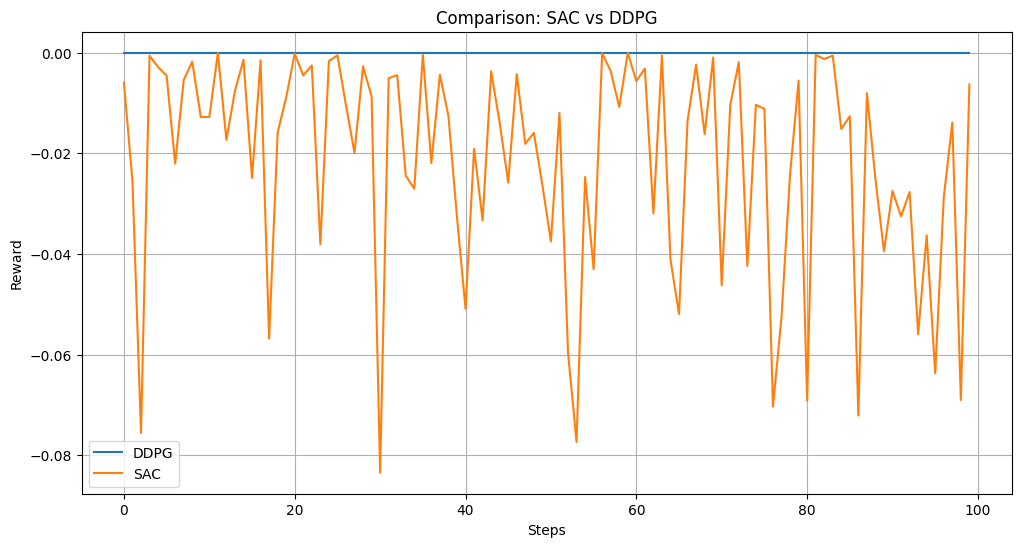

In [46]:
def plot_training_results(model_logs, model_names, total_steps=100):
    plt.figure(figsize=(12, 6))
    for i, logs in enumerate(model_logs):
        plt.plot(np.arange(0, total_steps, 1), logs["reward"][:total_steps], label=model_names[i])

    plt.title("Comparison: SAC vs DDPG")
    plt.xlabel("Steps")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

ddpg_logs = {"reward": []}
sac_logs = {"reward": []}

ddpg_logs["reward"] = rew_DAC

sac_logs["reward"] = rew_SAC

plot_training_results([ddpg_logs, sac_logs], ["DDPG", "SAC"])

# Эксперименты с LR

## №1

In [56]:
import gymnasium as gym
env = gym.make('MountainCarContinuous-v0')

learning_rates = [0.0001, 0.001, 0.01]
sac_reward = {0.0001:[],0.001:[],0.01:[]}

for lr in learning_rates:
    model = SAC('MlpPolicy', env, learning_rate=lr, verbose=1)

    model.learn(total_timesteps=3000)

    obs, info = env.reset()
    for i in range(500):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        sac_reward[lr].append(reward)
        if terminated or truncated:
            obs, info = env.reset()

# Закрытие среды
env.close()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [57]:
print(sum(sac_reward[0.0001])/len(sac_reward[0.0001]))
print(sum(sac_reward[0.001])/len(sac_reward[0.001]))
print(sum(sac_reward[0.01])/len(sac_reward[0.01]))

-4.492766429743262e-06
-5.750772089726293e-07
-1.0444268087894667e-08


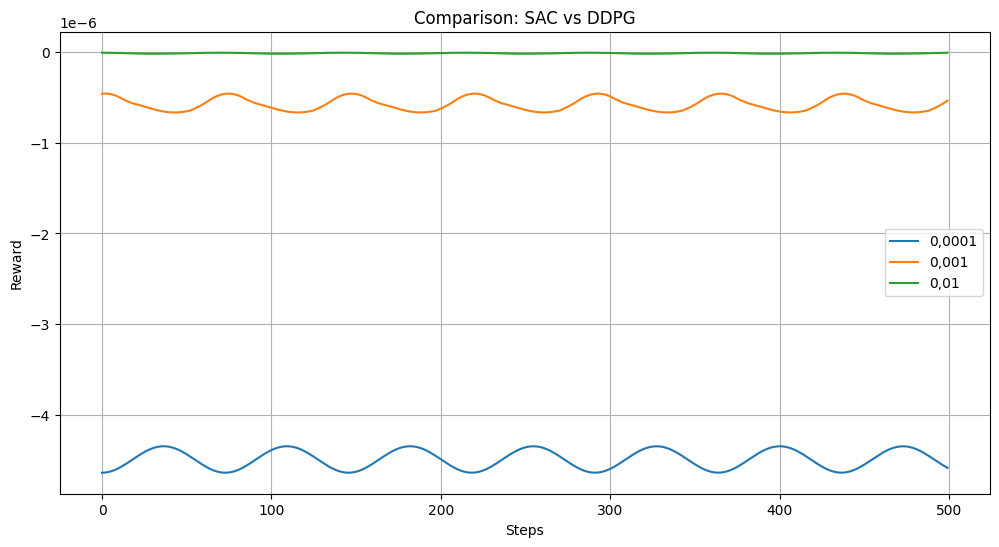

In [59]:
sac_e4,sac_e3,sac_e2 = {}, {}, {}

sac_e4["reward"] = sac_reward[0.0001]

sac_e3["reward"] = sac_reward[0.001]

sac_e2["reward"] = sac_reward[0.01]
plot_training_results([sac_e4, sac_e3, sac_e2], ["0,0001", "0,001", "0,01"], total_steps=500)

## №2

In [66]:
import gymnasium as gym
env = gym.make('MountainCarContinuous-v0')

learning_rates = [0.0003, 0.00253, 0.07]
sac_reward = {0.0003:[],0.00253:[],0.07:[]}

for lr in learning_rates:
    model = SAC('MlpPolicy', env, learning_rate=lr, verbose=1)

    model.learn(total_timesteps=3000)

    obs, info = env.reset()
    for i in range(500):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        sac_reward[lr].append(reward)
        if terminated or truncated:
            obs, info = env.reset()

# Закрытие среды
env.close()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [67]:
print(sum(sac_reward[0.0003])/len(sac_reward[0.0003]))
print(sum(sac_reward[0.00253])/len(sac_reward[0.00253]))
print(sum(sac_reward[0.07])/len(sac_reward[0.07]))

-1.2651819666388066e-06
-1.0779062991225183e-05
-2.8357291797931107e-05


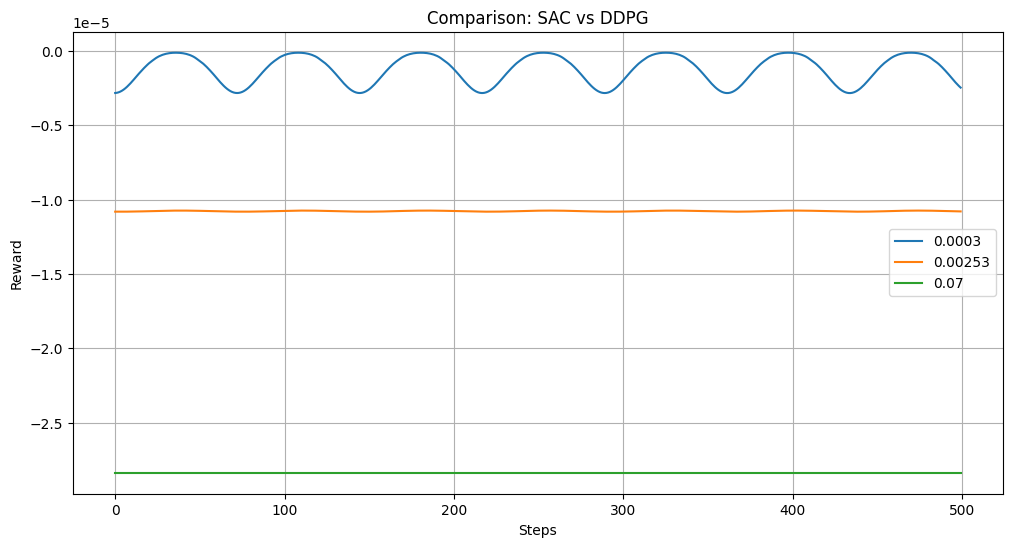

In [69]:
sac_e4,sac_e3,sac_e2 = {}, {}, {}

sac_e4["reward"] = sac_reward[0.0003]

sac_e3["reward"] = sac_reward[0.00253]

sac_e2["reward"] = sac_reward[0.07]
plot_training_results([sac_e4, sac_e3, sac_e2], ["0.0003", "0.00253", "0.07"], total_steps=500)